In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib_venn import venn3
from multiprocessing import Pool

def get_ko_sensitivity(coords, wt_ko_table):
    sensitivity = np.array([wt_ko_table[(coord[0], int(coord[1]))] 
                            for coord in coords if coord in wt_ko_table])
    sensitivity_filtered = sensitivity < 0.05
    return round(np.sum(sensitivity_filtered) / len(sensitivity_filtered), 2)

def generate_venn(df, col, threshold, wt_ko_table, axes):    
    m6ace_drach = df[df["m6ACE"] == 1]
    miclip_drach = df[df["miCLIP"] == 1]
    pred_df_positive = df[df["probability_modified_{}".format(col)] >= threshold]
    
    m6ace_coords = set((x, int(y)) for x, y in m6ace_drach[["chr", "genomic_position"]].values)
    miclip_coords = set((x, int(y)) for x, y in miclip_drach[["chr", "genomic_position"]].values if (x==x and y==y))
    m6anet_coords = set((x, int(y)) for x, y in pred_df_positive[["chr", "genomic_position"]].values)

    m6ace_miclip = set([x for x in m6ace_coords.intersection(miclip_coords) if x not in 
                             m6anet_coords])
    m6ace_m6anet = set([x for x in m6ace_coords.intersection(m6anet_coords) if x not in 
                             miclip_coords])
    m6anet_miclip = set([x for x in m6anet_coords.intersection(miclip_coords) if x not in 
                              m6ace_coords])
    all_intersections = m6ace_coords.intersection(miclip_coords).intersection(m6anet_coords)

    m6ace_only = set([coord for coord in m6ace_coords if ((coord not in m6ace_m6anet) and (coord not in m6ace_miclip)
                                                          and (coord not in all_intersections))])
    miclip_only = set([coord for coord in miclip_coords if ((coord not in m6ace_miclip) and (coord not in m6anet_miclip)
                                                          and (coord not in all_intersections))])
    m6anet_only = set([coord for coord in m6anet_coords if ((coord not in m6ace_m6anet) and (coord not in m6anet_miclip)
                                                          and (coord not in all_intersections))])

    out1 = venn3(subsets=(len(m6ace_only),
                          len(miclip_only),
                          len(m6ace_miclip),
                          len(m6anet_only),
                          len(m6ace_m6anet), len(m6anet_miclip), len(all_intersections)),
                 set_labels = ('m6ACE', 'miCLIP', 'm6ANet'), alpha = 0.5, ax=axes[0])

    out2 = venn3(subsets=(get_ko_sensitivity(m6ace_only, wt_ko_table),
                          get_ko_sensitivity(miclip_only, wt_ko_table),
                          get_ko_sensitivity(m6ace_miclip, wt_ko_table),
                          get_ko_sensitivity(m6anet_only, wt_ko_table),
                          get_ko_sensitivity(m6ace_m6anet, wt_ko_table),
                          get_ko_sensitivity(m6anet_miclip, wt_ko_table),
                          get_ko_sensitivity(all_intersections, wt_ko_table)),
                 set_labels = ('m6ACE', 'miCLIP', 'm6ANet'), alpha = 0.5, ax=axes[1])
    for out in [out1, out2]:
        for text in out.set_labels:
            text.set_fontsize(25)
        for text in out.subset_labels:
            text.set_fontsize(25)
    axes[0].set_title("Sites captured", fontdict={'fontsize': 25})
    axes[1].set_title("Knockout sensitivity", fontdict={'fontsize': 25})
    

In [2]:
from pyensembl import Genome
from tqdm.notebook import tqdm

def get_y(info_df, table, col_name):
    g, chrsm = info_df["genomic_position"].values, info_df["chr"].values
    info_df[col_name] = np.array([1 if (g_pos, chr_id) in table.index else 0
                                               for g_pos, chr_id in tqdm(zip(g, chrsm), total=len(g),
                                               desc="Getting label information")]) 
    return info_df


def add_chromosome_and_gene_info(info_df):
    info_df["chr"] = info_df["transcript_id"].apply(lambda x: chr_map[genome.transcript_by_id(x).contig])
    info_df["gene_id"] = info_df["transcript_id"].apply(lambda x: genome.transcript_by_id(x).gene_id)
    return info_df


def _add_genomic_position(task):
    tx, tx_df = task
    gt_map = pd.read_csv(os.path.join(gt_dir, tx, "gt_mapping.csv.gz")).set_index("tx_pos")
    tx_df["genomic_position"] = gt_map["g_pos"].loc[tx_df["transcript_position"]].values
    tx_df["kmer"] = gt_map["kmer"].loc[tx_df["transcript_position"]].values
    return tx_df


def add_genomic_position(info_df, n_jobs=25):
    with Pool(n_jobs) as p:
        tasks = ((tx, df) for tx, df in info_df.groupby("transcript_id"))
        n_transcripts = len(info_df.transcript_id.unique())
        res_df = [x for x in tqdm(p.imap_unordered(_add_genomic_position, tasks), total=n_transcripts)]
    return pd.concat(res_df).reset_index(drop=True)


chrsm_annot_dir = "/data03/christopher/annotations/chrsm_annot.txt"
genome = Genome(reference_name='GRCh38',
            annotation_name='my_genome_features',
            gtf_path_or_url='/data03/christopher/annotations/Homo_sapiens.GRCh38.91.chr_patch_hapl_scaff.gtf',
            transcript_fasta_paths_or_urls='/data03/christopher/annotations/Homo_sapiens.GRCh38.cdna.ncrna.fa') 
chr_map = {}
with open(chrsm_annot_dir) as f:
    for line in f:
        ensembl, ucsc = line.strip("\n").split("\t")
        chr_map[ensembl] = ucsc

m6ace = pd.read_csv("/data03/christopher/annotations/m6ACE_HEK293T.csv.gz").set_index(["End", "Chr"])
miclip = pd.read_csv("/data03/christopher/annotations/miclip_HEK293T.csv.gz").set_index(["End", "Chr"])
gt_dir = "/data03/christopher/gt_mapping_final/"

model_dir = "/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T_directRNA_Rep2/prod_pooling"
result = pd.read_csv(os.path.join(model_dir, "data.result.csv"))
result = add_chromosome_and_gene_info(result)
result = add_genomic_position(result)
result = result.rename({'probability_modified': "probability_modified_prod_pooling"}, axis=1)

result = result[["gene_id", "genomic_position", "transcript_id", "transcript_position", "chr",
                 "probability_modified_prod_pooling"]]
result = result.groupby(["gene_id", "genomic_position", "chr"]).mean().reset_index()
            
result = get_y(result, m6ace, "m6ACE")
result = get_y(result, miclip, "miCLIP")

  0%|          | 0/4662 [00:00<?, ?it/s]

Getting label information:   0%|          | 0/75369 [00:00<?, ?it/s]

Getting label information:   0%|          | 0/75369 [00:00<?, ?it/s]

/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2940: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


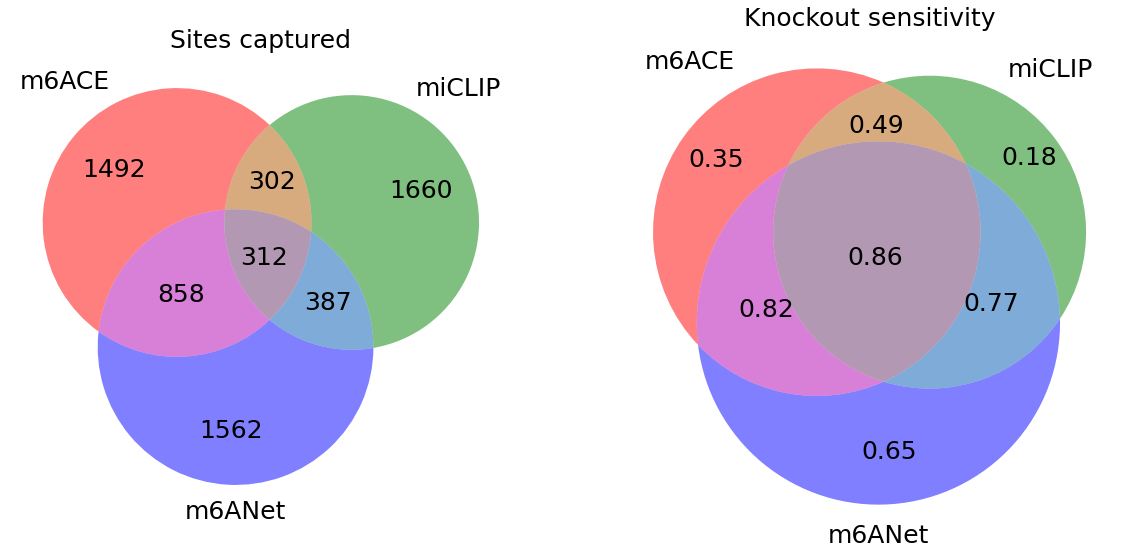

In [3]:
from statsmodels.stats.multitest import multipletests
 
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
wt_ko_table = pd.read_csv("/data03/christopher/wt_ko_hek293_ttest/ttest_results.csv.gz")
wt_ko_table["padj"] = multipletests(wt_ko_table.pvalue, alpha=0.05, method='fdr_bh')[1]
wt_ko_table["chr"] = wt_ko_table["gene_id"].apply(lambda x: chr_map[genome.gene_by_id(x).contig])
wt_ko_table = wt_ko_table.set_index(["chr", "genomic_position"])
wt_ko_table = wt_ko_table["padj"].to_dict()
generate_venn(result, "prod_pooling", 0.9, wt_ko_table, axes)

In [4]:
def create_tx_ref(transcript_ids):
    transcript_lengths = []
    for tx_id in tqdm(transcript_ids):
        try:
            tx = genome.transcript_by_id(tx_id)
        except Exception:
            continue
        end_tx = len(tx.sequence)
        if tx.contains_start_codon and tx.contains_stop_codon:
            end_5utr = len(tx.five_prime_utr_sequence)
            end_cds = tx.last_stop_codon_spliced_offset
            if end_tx > end_cds > end_5utr > 0:
                transcript_lengths += [(tx_id,end_5utr,end_cds,end_tx)]
    return pd.DataFrame(transcript_lengths,columns = ['transcript_id','end_5utr','end_cds','end_tx'])

def plot_rel_positions(ax,df,df_transcript_lengths, label):
    df = df.merge(df_transcript_lengths,how='inner',on='transcript_id')
    df['isin_5utr'] = df['transcript_position'] < df['end_5utr']
    df['isin_cds'] = (~df['isin_5utr']) & (df['transcript_position'] < df['end_cds'])
    df['isin_3utr'] = (~df['isin_5utr']) & (~df['isin_cds']) #& (df['tx_pos'] < df['end_tx'])
    len_cds = df['end_cds']-df['end_5utr']
    len_3utr = df['end_tx']-df['end_cds']
    
    assert (len_cds > 0).all()
    assert (len_3utr > 0).all()

    rel_len_5utr = df['isin_5utr']*(df['transcript_position']/df['end_5utr'])
    rel_len_cds = df['isin_cds']*((df['transcript_position']-df['end_5utr'])/len_cds)
    rel_len_3utr = df['isin_3utr']*((df['transcript_position']-df['end_cds'])/len_3utr)
    
    df['rel_5utr'] = rel_len_5utr
    df['rel_cds'] = rel_len_cds
    df['rel_3utr'] = rel_len_3utr
    
    rel_positions = list(rel_len_5utr[rel_len_5utr>0])
    rel_positions += list(rel_len_cds[rel_len_cds>0] + 1)
    rel_positions += list(rel_len_3utr[rel_len_3utr>0] + 2)
    sns.kdeplot(rel_positions, bw='scott', shade=True, cut=True, ax=ax, label=label)
    ax.set_xticks([1,2,3])
    ax.set_xticklabels([])
    ######### annotating the x axis   #########
    ax.annotate("", xy=(0, -0.05),xytext=(1,-0.05), xycoords='data',               
                arrowprops=dict(arrowstyle='<->',facecolor='red'),
                annotation_clip=False)
    ax.annotate("5'UTR",xy=(0.5, -0.2),xytext=(0.5,-0.2),             
                annotation_clip=False)
    ax.annotate("", xy=(1, -0.05),xytext=(2,-0.05), xycoords='data',               
                arrowprops=dict(arrowstyle='<->',facecolor='red'),
                annotation_clip=False) 
    ax.annotate("CDS",xy=(1.5, -0.2),xytext=(1.5,-0.2),             
                annotation_clip=False)
    ax.annotate("", xy=(2, -0.05),xytext=(3,-0.05), xycoords='data',               
                arrowprops=dict(arrowstyle='<->',facecolor='red'),
                annotation_clip=False) 
    ax.annotate("3'UTR",xy=(2.5, -0.2),xytext=(2.5,-0.2),             
                annotation_clip=False)
    ax.axvline(1, ymin=0, color='black', linestyle="--")
    ax.axvline(2, ymin=0, color='black', linestyle="--")
    ax.set_xlim([0,3])
    ax.set_ylabel('Density')
#     ax.legend(bbox_to_anchor=(0,1.01,1,0.1),loc='center left',ncol=len(df),mode='expand',frameon=False)
    return ax

def get_modified_positions(inference_df, threshold):
    return inference_df[inference_df["probability_modified"] >= threshold]

In [5]:
result_tx = pd.read_csv(os.path.join(model_dir, "data.result.csv"))
result_tx = add_chromosome_and_gene_info(result_tx)
result_tx = add_genomic_position(result_tx)
tx_ref = create_tx_ref(result["transcript_id"].unique())

  0%|          | 0/4662 [00:00<?, ?it/s]

KeyError: 'transcript_id'

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_rel_positions(ax, get_modified_positions(result, 0.8), tx_ref, label="m6ANet")
plot_rel_positions(ax, get_modified_positions(result, 0), tx_ref, label="Background")
plt.legend()

In [48]:
threshold = 0.8
pred_df_positive = result[result["probability_modified_prod_pooling"] >= threshold]
m6ace_drach = result[result["m6ACE"] == 1]
miclip_drach = result[result["miCLIP"] == 1]

m6ace_coords = set((x, int(y)) for x, y in m6ace_drach[["chr", "genomic_position"]].values)
miclip_coords = set((x, int(y)) for x, y in miclip_drach[["chr", "genomic_position"]].values if (x==x and y==y))
m6anet_coords = set((x, int(y)) for x, y in pred_df_positive[["chr", "genomic_position"]].values)

m6ace_miclip = set([x for x in m6ace_coords.intersection(miclip_coords) if x not in 
                         m6anet_coords])
m6ace_m6anet = set([x for x in m6ace_coords.intersection(m6anet_coords) if x not in 
                         miclip_coords])
m6anet_miclip = set([x for x in m6anet_coords.intersection(miclip_coords) if x not in 
                          m6ace_coords])
all_intersections = m6ace_coords.intersection(miclip_coords).intersection(m6anet_coords)

m6ace_only = set([coord for coord in m6ace_coords if ((coord not in m6ace_m6anet) and (coord not in m6ace_miclip)
                                                      and (coord not in all_intersections))])
miclip_only = set([coord for coord in miclip_coords if ((coord not in m6ace_miclip) and (coord not in m6anet_miclip)
                                                      and (coord not in all_intersections))])
m6anet_only = set([coord for coord in m6anet_coords if ((coord not in m6ace_m6anet) and (coord not in m6anet_miclip)
                                                      and (coord not in all_intersections))])


In [42]:
result_tx = pd.read_csv(os.path.join(model_dir, "data.result.csv"))
result_tx = add_chromosome_and_gene_info(result_tx)
result_tx = add_genomic_position(result_tx)

  0%|          | 0/4662 [00:00<?, ?it/s]

/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using scott for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using scott for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

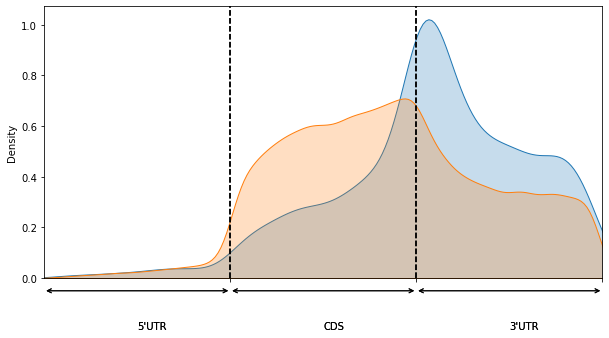

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
m6anet_only_df = result_tx.set_index(["chr", "genomic_position"]).loc[np.array(m6anet_only)].reset_index()
plot_rel_positions(ax, m6anet_only_df, tx_ref, label="Threshold:0.9")
plot_rel_positions(ax, get_modified_positions(result_tx, 0), tx_ref, label="Threshold:0")